# RAPTOR: Tree-Organized Retrieval for Enhanced Information Access





RAPTOR (Recursive Abstractive Processing for Tree-Organized Retrieval) builds a hierarchical tree structure by clustering and summarizing text recursively. This innovative approach enables retrieval at different abstraction levels, allowing the model to combine broad themes with specific details effectively. RAPTOR outperforms traditional methods in complex question-answering tasks by providing a more nuanced understanding of the information landscape. The system offers both tree traversal and collapsed tree methods for efficient information retrieval.



## Key Features of RAPTOR



- **Hierarchical Tree Structure**: Constructs a tree by recursively clustering and summarizing text, facilitating effective synthesis of information from various levels of detail.

- **Abstraction Levels**: Enables retrieval at different abstraction levels, allowing users to access both high-level themes and specific details as needed.

- **Enhanced Question Answering**: Outperforms traditional retrieval methods in complex question-answering tasks by integrating contextual information across multiple layers of the tree.

- **Efficient Retrieval Methods**: Offers both tree traversal and collapsed tree methods, optimizing the information retrieval process based on user needs.



## How RAPTOR Works



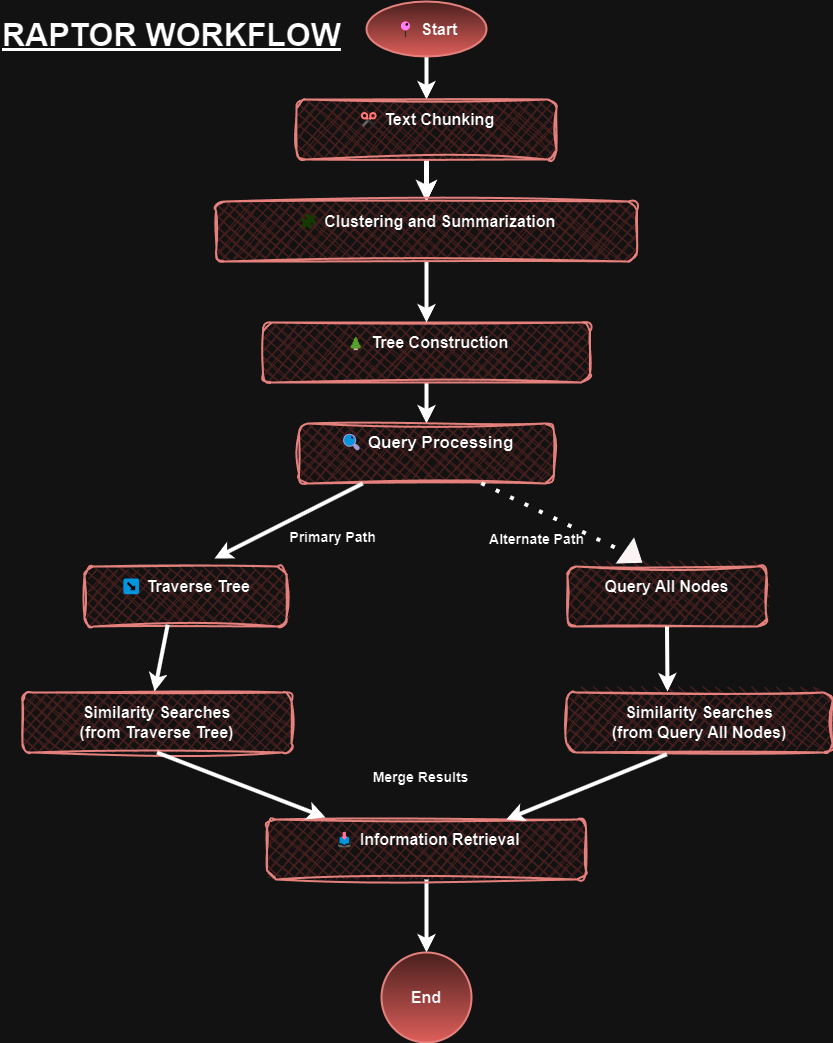

1. **Text Chunking**: The process begins by chunking the retrieval corpus into manageable pieces, ensuring that chunks are not split across sentences for coherent summaries.

2. **Clustering and Summarization**: Text chunks are clustered using a clustering algorithm (e.g., Gaussian Mixture Models) and summarized recursively. This creates layers of information that capture relationships between child nodes.

3. **Tree Construction**: A hierarchical tree structure is built from the bottom up, where each node represents a cluster of related text chunks. This structure allows for both high-level overviews and detailed insights.

4. **Query Processing**:
   - During query time, users can either traverse the tree from root nodes or query all nodes as a flat list.
   - The system conducts similarity searches at each level of the tree to find relevant information efficiently.

5. **Information Retrieval**: By integrating context from various levels within the tree, RAPTOR enhances its ability to provide accurate answers to complex questions that require understanding across multiple themes.



In [ ]:
!pip install pypdf2 groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 7.2 MB/s eta 0:00:00


In [ ]:
import os
import requests
from PyPDF2 import PdfReader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from groq import Groq

In [ ]:
# Step 1: Initialize the Groq client
client = Groq(api_key="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")

In [ ]:
# Step 2: Download and process the PDF document
pdf_url = "https://arxiv.org/pdf/1810.04805.pdf"  # Example: BERT paper
pdf_path = "BERT_paper.pdf"

In [ ]:
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as pdf_file:
    pdf_file.write(response.content)


In [ ]:
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text()

In [ ]:
# Step 3: Define the query
query = "What is SQuAD v1.1?"

In [ ]:
# Step 4: Chunk the document for processing
chunks = [text[i:i + 1000] for i in range(0, len(text), 1000)]  # Divide document into manageable chunks

In [ ]:
# Step 5: Vectorize the chunks for clustering
vectorizer = TfidfVectorizer()
chunk_embeddings = vectorizer.fit_transform(chunks)

In [ ]:
# Step 6: Clustering using Gaussian Mixture Models (GMM)
gmm = GaussianMixture(n_components=5, random_state=42)
labels = gmm.fit_predict(chunk_embeddings.toarray())

In [ ]:
# Step 7: Build a hierarchical tree structure
tree = {}
for label, chunk in zip(labels, chunks):
    if label not in tree:
        tree[label] = []
    tree[label].append(chunk)

In [ ]:
# Step 8: Query Processing and Similarity Search
def search_tree(tree, query_embedding, vectorizer):
    best_matches = []
    for label, node_chunks in tree.items():
        # Vectorize the chunks within the node
        node_embeddings = vectorizer.transform(node_chunks)
        # Compute similarity with the query
        similarities = cosine_similarity(query_embedding, node_embeddings).flatten()
        # Retrieve the most relevant chunk from the node
        top_chunk_index = similarities.argmax()
        best_matches.append((similarities[top_chunk_index], node_chunks[top_chunk_index]))

    # Sort all matches by similarity and return the top ones
    best_matches = sorted(best_matches, key=lambda x: x[0], reverse=True)
    return best_matches[:5]  # Top 5 matches

In [ ]:
query_embedding = vectorizer.transform([query])
retrieved_chunks = search_tree(tree, query_embedding, vectorizer)

In [ ]:
# Step 9: Send retrieved chunks to Groq for answer generation
module_results = []
for _, chunk in retrieved_chunks:
    try:
        combined_input = f"Query: {query}\nRelevant information: {chunk}"

        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a highly knowledgeable assistant."},
                {"role": "user", "content": combined_input},
            ],
            model="llama3-8b-8192",
        )

        answer = response.choices[0].message.content
        module_results.append({"chunk": chunk[:200], "answer": answer})

    except Exception as e:
        print(f"Error generating answer: {e}")

In [ ]:
# Step 10: Output the best result
best_result = max(module_results, key=lambda x: len(x["answer"]))
print("\nBest result based on module evaluation:")
print(f"Chunk: {best_result['chunk']}\nAnswer: {best_result['answer']}")


Best result based on module evaluation:
Chunk: t named entity recognition. In
CoNLL .
Joseph Turian, Lev Ratinov, and Yoshua Bengio. 2010.
Word representations: A simple and general method
for semi-supervised learning. In Proceedings of the
48th A
Answer: SQuAD v1.1 (Stanford Question Answering Dataset v1.1) is a reading comprehension dataset, specifically designed for evaluating the ability of AI models to answer questions based on a passage of text. The dataset consists of 100,000+ question-answer pairs, where each pair is associated with a passage of text from a Wikipedia article.

In SQuAD v1.1, the questions are designed to be challenging and require the model to understand the context, syntax, and semantics of the passage to accurately answer the question. The dataset includes a mix of multiple-choice and open-ended questions, and the answers can range from a single word to several sentences.

SQuAD v1.1 is widely used in the natural language processing (NLP) and machine learnin

## Workflow Explanation

## PDF Processing
The code starts by downloading and processing the text from the BERT paper PDF. The document is split into manageable text chunks, ensuring coherence by not splitting across sentences.

## Text Chunking
The text is divided into chunks, which are the base units for further analysis. Each chunk is treated as a node for clustering and later for hierarchical tree construction.

## Clustering (Tree Base)
Using Gaussian Mixture Models (GMM), text chunks are grouped into clusters based on their semantic similarity. These clusters represent related sets of information and form the foundational layers (leaves) of the hierarchical tree.

## Summarization and Recursive Tree Construction
Summarization is performed recursively:
- Each cluster is summarized into a single node to provide a condensed view of the underlying chunks.
- These summarized nodes are grouped again, forming a higher-level cluster.
- This process continues iteratively, building the tree structure from the bottom up, with parent nodes representing broad overviews and child nodes capturing granular details.

## Tree Hierarchy Overview
- **Root Node**: Represents the most generalized summary of the document.
- **Intermediate Nodes**: Capture relationships between related themes or concepts across clusters.
- **Leaf Nodes**: Contain specific details from the original text chunks.

## Query Input
The user query, such as "What is SQuAD v1.1?", initiates the retrieval process. This query is embedded using TF-IDF to match its semantic similarity with nodes in the tree.

## Query Traversal and Node Similarity
The system traverses the hierarchical tree:
- Starting at the root node, the query is compared with nodes at each level using cosine similarity.
- Relevant nodes are selected, either from the current level or by diving deeper into child nodes.

## Information Aggregation
Relevant information from selected nodes across the tree is aggregated. The hierarchical structure ensures that both high-level context (parent nodes) and detailed insights (child nodes) are included in the final input.

## Groq API for RAPTOR Reasoning
The retrieved information is prepended to the query, forming a combined input. This input is sent to the Groq API, which generates an answer based on the hierarchical reasoning facilitated by the RAPTOR approach.

## Answer Generation and Feedback
Groq produces a detailed response by reasoning over the hierarchical context. Feedback can be used to refine the clustering process or improve future queries.


## Applications of RAPTOR



- **Complex Question Answering**: Particularly effective in scenarios requiring multi-hop reasoning or thematic understanding, such as narrative comprehension tasks.

- **Knowledge Management Systems**: Facilitates efficient access to large volumes of information organized hierarchically, improving user experience in retrieving relevant data.

- **Content Creation Tools**: Assists writers and researchers in synthesizing information from extensive sources while maintaining coherence and context in their outputs.

- **Educational Platforms**: Enhances learning tools by providing structured access to educational content, allowing learners to explore topics at varying levels of detail.



## Advantages of RAPTOR



- **Improved Contextual Understanding**: By organizing information hierarchically, RAPTOR provides a more comprehensive view of the content, enhancing the model's ability to answer complex queries.

- **Flexibility in Information Retrieval**: The ability to retrieve information at various abstraction levels allows users to tailor their queries according to their specific needs.

- **Enhanced Performance on Complex Tasks**: RAPTOR's design allows it to excel in multi-hop question-answering scenarios, where understanding relationships between different pieces of information is crucial.

- **Scalability**: The tree structure can efficiently manage large volumes of data, making it suitable for extensive corpora and diverse applications.



## Limitations of RAPTOR



- **Complexity in Implementation**: Building and maintaining a hierarchical tree structure can introduce complexity, requiring careful management and design considerations.

- **Resource Intensive**: The recursive clustering and summarization processes may demand significant computational resources, particularly with large datasets.

- **Dependence on Clustering Quality**: The effectiveness of RAPTOR relies heavily on the quality of the clustering algorithms used; suboptimal clustering can lead to ineffective retrievals.



## Conclusion



RAPTOR represents a significant advancement in retrieval-augmented generation methodologies by employing a hierarchical approach to information organization. Its ability to cluster and summarize text recursively enhances contextual understanding and improves performance on complex question-answering tasks. As AI continues to evolve, RAPTOR stands out as a promising solution for effectively managing and retrieving large-scale information across various applications.



Having explored RAPTOR, we will now move on to REVEAL for Visual-Language Model.